In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn import naive_bayes #import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier # simulate the behavior of logistic regression using SGDClassifier(loss='log')
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score,average_precision_score, classification_report
from sklearn.metrics import f1_score

from sklearn.utils import shuffle
from collections import Counter
from itertools import product

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# Load the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)
len(loaded_vectorizer.get_feature_names_out())

train_df = pd.read_csv('cfpb_train.csv')
test_df = pd.read_csv('cfpb_test.csv')
dev_df = pd.read_csv('cfpb_dev.csv')

C:\Users\JYM\AppData\Local\Temp/ipykernel_23788/2270551363.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')
C:\Users\JYM\AppData\Local\Temp/ipykernel_23788/2270551363.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dev_df = pd.read_csv('cfpb_dev.csv')


In [4]:
# some cleaning just ot make sure
train_df['Consumer complaint narrative'] = train_df['Consumer complaint narrative'].fillna('').astype(str)
test_df['Consumer complaint narrative'] = test_df['Consumer complaint narrative'].fillna('').astype(str)
dev_df['Consumer complaint narrative'] = dev_df['Consumer complaint narrative'].fillna('').astype(str)

train_df['debt_collection'] = (train_df['Product'] == 'Debt collection').astype(int)
test_df['debt_collection'] = (test_df['Product'] == 'Debt collection').astype(int)
dev_df['debt_collection'] = (dev_df['Product'] == 'Debt collection').astype(int)

In [5]:
%%time
X_test = loaded_vectorizer.transform(test_df['Consumer complaint narrative'])
y_test = test_df['debt_collection']

X_dev = loaded_vectorizer.transform(dev_df['Consumer complaint narrative'])
y_dev = dev_df['debt_collection']

Wall time: 58.6 s


### Grid Search Model

In [7]:
%%time
# # Define the parameters for exploration
# # First Run
param_grid = {
    'sample_size': [100000, 200000, 300000], 
    'chi2_features': [20000, 25000, 30000], 
    'clf__n_estimators': [50, 100],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [10, 30, 50],
    'clf__min_samples_split': [100, 500],
    'clf__min_samples_leaf': [50, 200],
    'clf__class_weight': [None, 'balanced'],
    'clf__bootstrap': [True, False]
}

def grid_search_model(param_grid, train_df, X_dev, y_dev):
    best_params = None
    best_score = 0
    prev_score = 0
    
    for sample_size in param_grid['sample_size']:
        for chi2_features in param_grid['chi2_features']:
            # Sample and transform the train data
            train_df_sample = train_df.sample(sample_size)
            
            X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
            y_train = train_df_sample['debt_collection']
            
            selector = SelectKBest(chi2, k=chi2_features)
            X_train = selector.fit_transform(X_train, y_train)
            # Transform dev set with the same selector
            X_dev_transformed = selector.transform(X_dev)
            
            oversample = RandomOverSampler(sampling_strategy='minority')
            X_train, y_train = oversample.fit_resample(X_train, y_train)
            
            # Shuffle your data
            X_train, y_train = shuffle(X_train, y_train, random_state=42)
            
            for params in product(
                param_grid['clf__n_estimators'],
                param_grid['clf__criterion'],
                param_grid['clf__max_depth'],
                param_grid['clf__min_samples_split'],
                param_grid['clf__min_samples_leaf'],
                param_grid['clf__class_weight'],
                param_grid['clf__bootstrap']
            ):
                
                # Apply the parameters
                n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight, bootstrap = params

                clf = RandomForestClassifier(
                    n_estimators=n_estimators, 
                    criterion=criterion, 
                    max_depth=max_depth, 
                    min_samples_split=min_samples_split, 
                    min_samples_leaf=min_samples_leaf, 
                    class_weight=class_weight,
                    bootstrap=bootstrap,
                    random_state=42,
                    n_jobs = -1
                )
                # Train and score the model
                clf.fit(X_train, y_train)
                predicted = clf.predict(X_dev_transformed)
                score = f1_score(y_dev, predicted)
                
                if score > best_score:
                    best_score = score
                    best_params = {
                        'sample_size': sample_size,
                        'chi2_features': chi2_features,
                        'clf__n_estimators': n_estimators,
                        'clf__criterion': criterion,
                        'clf__max_depth': max_depth,
                        'clf__min_samples_split': min_samples_split,
                        'clf__min_samples_leaf': min_samples_leaf,
                        'clf__class_weight': class_weight,
                        'clf__bootstrap': bootstrap
                    }
                    print(f"New best score:{score} using {best_params}")
#                 else:
#                     print("*", score,sample_size,chi2_features)
#                     print("*",params)

                prev_score = score
                    
    return best_params

best_params = grid_search_model(param_grid, train_df, X_dev, y_dev)
print(f'Best parameters: {best_params}')

New best score:0.6332184473986542 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}
New best score:0.6341695985269457 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}
New best score:0.6642955298682403 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}
New best score:0.6673555720605805 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split

In [8]:
%%time
# Assign the values from the dictionary to the variables
sample_size = best_params['sample_size']
chi2_features = best_params['chi2_features']
n_estimators = best_params['clf__n_estimators']
criterion = best_params['clf__criterion']
max_depth = best_params['clf__max_depth']
min_samples_split = best_params['clf__min_samples_split']
min_samples_leaf = best_params['clf__min_samples_leaf']
class_weight = best_params['clf__class_weight']
bootstrap = best_params['clf__bootstrap']

# Continue with the rest of your code as it was before
train_df_sample = train_df.sample(sample_size)

X_train = loaded_vectorizer.transform(train_df_sample['Consumer complaint narrative'])
y_train = train_df_sample['debt_collection']

selector = SelectKBest(chi2, k=chi2_features)
X_train = selector.fit_transform(X_train, y_train)
# Transform dev set with the same selector
X_dev_transformed = selector.transform(X_dev)

oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

clf = RandomForestClassifier(
    n_estimators=n_estimators, 
    criterion=criterion, 
    max_depth=max_depth, 
    min_samples_split=min_samples_split, 
    min_samples_leaf=min_samples_leaf, 
    class_weight=class_weight,
    bootstrap=bootstrap,
    random_state=42,
    n_jobs = -1
)
clf.fit(X_train, y_train)


Wall time: 1min 8s


RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=50,
                       min_samples_leaf=50, min_samples_split=100,
                       n_estimators=50, n_jobs=-1, random_state=42)

Train
accuracy_score 0.8309971682847896
balanced_accuracy_score 0.8309971682847896
average_precision_score 0.7982955705649846
              precision    recall  f1-score   support

           0       0.78      0.92      0.84    247200
           1       0.90      0.74      0.81    247200

    accuracy                           0.83    494400
   macro avg       0.84      0.83      0.83    494400
weighted avg       0.84      0.83      0.83    494400

Prediction [(0, 290457), (1, 203943)]
Ground Truth [(0, 247200), (1, 247200)]


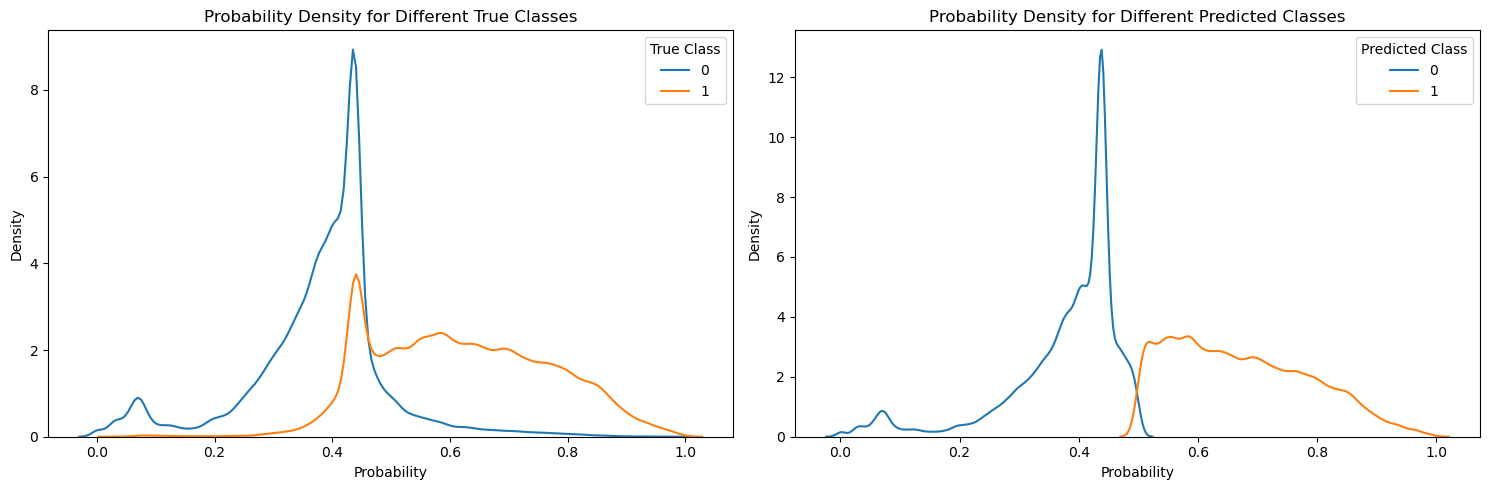

In [9]:
# get the results
y_pred = clf.predict(X_train.toarray())
y_pred_proba = clf.predict_proba(X_train.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_train, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_train, y_pred))
print("average_precision_score",average_precision_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_train)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_train

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

Train
accuracy_score 0.8857808716707022
balanced_accuracy_score 0.8270575172766337
average_precision_score 0.5307747405116027
              precision    recall  f1-score   support

           0       0.94      0.92      0.93    136036
           1       0.66      0.74      0.69     29164

    accuracy                           0.89    165200
   macro avg       0.80      0.83      0.81    165200
weighted avg       0.89      0.89      0.89    165200

Prediction [(0, 132549), (1, 32651)]
Ground Truth [(0, 136036), (1, 29164)]


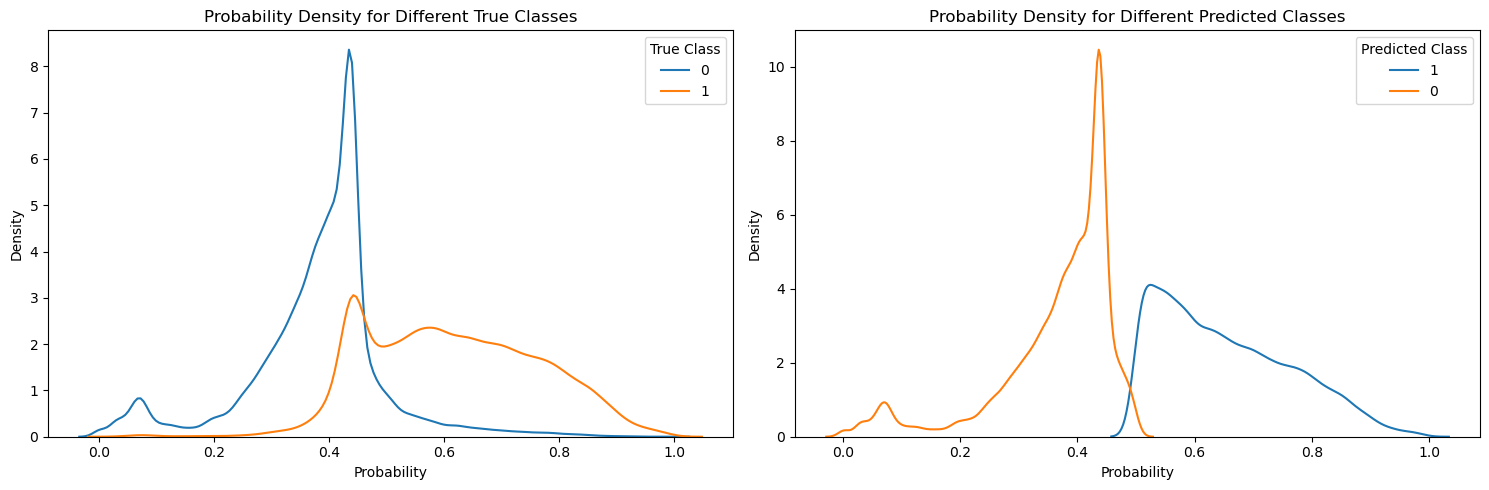

In [10]:
# get the results
y_pred = clf.predict(X_dev_transformed.toarray())
y_pred_proba = clf.predict_proba(X_dev_transformed.toarray())

# Convert lists to arrays for further use
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print("Train")
print("accuracy_score",accuracy_score(y_dev, y_pred))
print("balanced_accuracy_score",balanced_accuracy_score(y_dev, y_pred))
print("average_precision_score",average_precision_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

c = Counter(y_pred)
print("Prediction", c.most_common(2))
c = Counter(y_dev)
print("Ground Truth",c.most_common(2))

prediction = pd.DataFrame(y_pred_proba)
prediction['result'] = y_pred

df = prediction.copy()
df.columns = ['neg', 'pos', 'class']
df['true'] = y_dev

fig, axs = plt.subplots(ncols=2, figsize=(15, 5)) # Adjust figsize as needed

# Plot Probability Density for Different True Classes
for class_label in df['true'].unique():
    sns.kdeplot(df[df['true'] == class_label]['pos'], label=class_label, ax=axs[0])

axs[0].set_title('Probability Density for Different True Classes')
axs[0].set_xlabel('Probability')
axs[0].set_ylabel('Density')
axs[0].legend(title='True Class')

# Plot Probability Density for Different Predicted Classes
for class_label in df['class'].unique():
    sns.kdeplot(df[df['class'] == class_label]['pos'], label=class_label, ax=axs[1])

axs[1].set_title('Probability Density for Different Predicted Classes')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Density')
axs[1].legend(title='Predicted Class')

plt.tight_layout()
plt.show()

### Random Forest

New best score:0.6332184473986542 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6341695985269457 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6642955298682403 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6673555720605805 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6685215140731156 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6770409536323196 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6806292706181472 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6815976585490003 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6831891066429117 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 100, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6837444052947339 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 100, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6844095589169951 using {'sample_size': 100000, 'chi2_features': 20000, 'clf__n_estimators': 100, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6845885093167702 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6881061598951508 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': True}

New best score:0.6889032466483604 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6906264553323377 using {'sample_size': 100000, 'chi2_features': 25000, 'clf__n_estimators': 100, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6908733103203536 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__n_estimators': 50, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.690875351932429 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__n_estimators': 100, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6916732572590668 using {'sample_size': 200000, 'chi2_features': 20000, 'clf__n_estimators': 100, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6938568507157464 using {'sample_size': 200000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6942864169194196 using {'sample_size': 200000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 30, 'clf__min_samples_split': 500, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.6982193365903832 using {'sample_size': 200000, 'chi2_features': 25000, 'clf__n_estimators': 50, 'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

New best score:0.7001348037225317 using {'sample_size': 300000, 'chi2_features': 30000, 'clf__n_estimators': 50, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}

Best parameters: {'sample_size': 300000, 'chi2_features': 30000, 'clf__n_estimators': 50, 'clf__criterion': 'entropy', 'clf__max_depth': 50, 'clf__min_samples_split': 100, 'clf__min_samples_leaf': 50, 'clf__class_weight': None, 'clf__bootstrap': False}